This project is based on a Kaggle competition.<br>
This data set contains information about applicants for a loan. The goal of this project is to build a classifier model that is able to accurately predict whether we should grant the loan or no to the applicant.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

__IMPORT AND UNDERSTANDING THE DATA__

In [2]:
# Read data
data = pd.read_csv('loan_classification.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
print(data.info(), '\n')
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB
None 

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          6

In [4]:
# Delete the 1st column
data.drop('Loan_ID', axis=1, inplace=True)

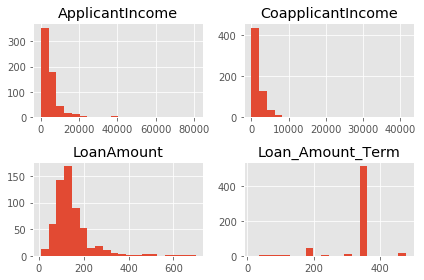

In [6]:
# Histogram of the numerical columns
data[['ApplicantIncome', 'CoapplicantIncome', 
      'LoanAmount', 'Loan_Amount_Term']].hist(bins=20)

plt.tight_layout()
plt.show()

Let's check the data repartition of the categorial variables.

In [7]:
print('Gender repartition')
print(data['Gender'].value_counts(), '\n')

print('Education level')
print(data['Education'].value_counts(), '\n')

print('Self-Employed')
print(data['Self_Employed'].value_counts(), '\n')

print('Credit history')
print(data['Credit_History'].value_counts(), '\n')

print('Property area')
print(data['Property_Area'].value_counts(), '\n')

print('Number of dependents')
print(data['Dependents'].value_counts())

Gender repartition
Male      489
Female    112
Name: Gender, dtype: int64 

Education level
Graduate        480
Not Graduate    134
Name: Education, dtype: int64 

Self-Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64 

Credit history
1.0    475
0.0     89
Name: Credit_History, dtype: int64 

Property area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64 

Number of dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


__FEATURES ENGINEERING__

Missing values

In [8]:
# Nan values for each column
data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
# Replacement by the mean or mode
for col in data.columns.values :
    # Categorical values
    if data[col].dtype == 'object' :
        data[col].fillna(value = data[col].value_counts().index[0], 
                         inplace = True)
    # Numerical values
    else : 
        data[col].fillna(value = data[col].mean(), 
                         inplace = True)

In [10]:
data.columns.isna().sum()

0

We now have 0 missing values.

Let's encode the label (we transform the categorical variables into numerical digits such as 1 for Female, 2 for Men for example).

In [11]:
columns = ['Gender', 'Married', 'Education', 'Dependents',
           'Self_Employed','Property_Area', 'Credit_History', 'Loan_Status']

data = pd.get_dummies(data, columns = columns, drop_first=True)
data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Education_Not Graduate,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Credit_History_0.8421985815602837,Credit_History_1.0,Loan_Status_Y
0,5849,0.0,146.412162,360.0,1,0,0,0,0,0,0,0,1,0,1,1
1,4583,1508.0,128.000000,360.0,1,1,0,1,0,0,0,0,0,0,1,0
2,3000,0.0,66.000000,360.0,1,1,0,0,0,0,1,0,1,0,1,1
3,2583,2358.0,120.000000,360.0,1,1,1,0,0,0,0,0,1,0,1,1
4,6000,0.0,141.000000,360.0,1,0,0,0,0,0,0,0,1,0,1,1


In [12]:
# Separate the independant variables from the target
X = data.drop('Loan_Status_Y', axis=1)

Y = data[['Loan_Status_Y']]

X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Education_Not Graduate,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Credit_History_0.8421985815602837,Credit_History_1.0
0,5849,0.0,146.412162,360.0,1,0,0,0,0,0,0,0,1,0,1
1,4583,1508.0,128.000000,360.0,1,1,0,1,0,0,0,0,0,0,1
2,3000,0.0,66.000000,360.0,1,1,0,0,0,0,1,0,1,0,1
3,2583,2358.0,120.000000,360.0,1,1,1,0,0,0,0,0,1,0,1
4,6000,0.0,141.000000,360.0,1,0,0,0,0,0,0,0,1,0,1


First, we'll split the data set into a train and test set. <br>

Then, we'll normalize the numerical data as they have a wide rande of values (the applicant income goes up to 81 000$ while the 'Married' variable will only take the values 0 and 1). <br>
Note than we don't normalize the target variable as its value is either 0 or 1.

In [13]:
# Split the data set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, 
                                                    random_state = 53)
X_train.shape, X_test.shape

((429, 15), (185, 15))

In [14]:
# Scale the numerical variables
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

__MODELING THE CLASSIFIERS__

The classifiers we'll use are :<br>
    . K Nearest Neighbors<br>
    . Logistic regression<br>
    . Decision tree

- K Nearest Neighbors

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print('Accuracy on train set :', knn.score(X_train, y_train))
print('Accuracy on test set :', knn.score(X_test, y_test))

Accuracy on train set : 0.8275058275058275
Accuracy on test set : 0.7189189189189189


The difference in accuracy between the train and test set shows our model tends to overfit the data : it is well suited to the training set but doesn't generalize to new examples with the same level of precision.
With some parameter-optimisation, we might be able to get better results.

In [16]:
# Compute the test & train accuracy with different number of k
K = 15
train_score = np.zeros(K-1)
test_score = np.zeros(K-1)

for k in np.arange(1, K) :
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_score[k-1] =  knn.score(X_train, y_train)
    test_score[k-1] = knn.score(X_test, y_test)

print('The highest accuracy on the test data is %f' %(np.max(test_score))) 
print('It is obtained with a KNN classifier of %d neighbors' %(np.argmax(test_score)+1))

The highest accuracy on the test data is 0.735135
It is obtained with a KNN classifier of 3 neighbors


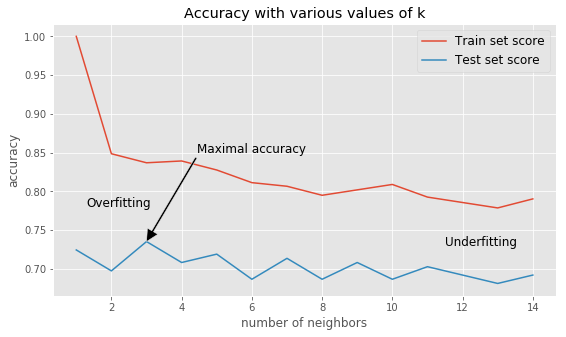

In [17]:
# Graph of the train and test accuracy
plt.figure(figsize=(9, 5))

plt.plot(np.arange(1, K), train_score, label='Train set score')
plt.plot(np.arange(1, K), test_score, label='Test set score')

# Annotate the graph
plt.annotate('Overfitting', (1.3, 0.78), fontsize = 12)
plt.annotate('Underfitting', (11.5, 0.73), fontsize = 12)

# Annotation and arrow
plt.annotate('Maximal accuracy', fontsize = 12, xytext = (6, 0.85),
             xy = (np.argmax(test_score)+1, np.max(test_score)),
             arrowprops = {'width' : 2, 'facecolor' : 'black'}, 
             horizontalalignment="center")
       
# Set axis, legend, title
plt.ylabel('accuracy')
plt.xlabel('number of neighbors')
plt.title ('Accuracy with various values of k')
plt.legend(prop={'size':12})

plt.show()

At k = 3, the model reaches an accuracy of 0.84 on the training set, and 0.73 on the testing set. <br>
Using more neighbors would deteriorate the performance of our algorithm, as it would tend to smooth the decision boundary too much, and thus underestimate the complexity of the data.

- Logistic Regression

In [18]:
logreg = LogisticRegression(C = 0.01, max_iter = 30, tol = 0.01)

logreg.fit(X_train, y_train)

print('Logistic train set accuracy :', logreg.score(X_train, y_train))
print('Logistic test set accuracy :', logreg.score(X_test, y_test), '\n')

Logistic train set accuracy : 0.8088578088578089
Logistic test set accuracy : 0.7621621621621621 



The Logistic model did perform sligthly better than the KNN algorithm on the test set (0.76 vs 0.72 before parameter optimisation). Let's perform a Grid Search to find the optimal parameters for the Logistic Regression classifier, and enhance its accuracy.

- Grid Search

In [19]:
params = dict(C = np.linspace(0.001, 1, 10), tol = [0.01, 0.001, 0.0001], 
          max_iter = np.arange(10, 50, 10))

log_grid = GridSearchCV(LogisticRegression(), params, cv=5)

log_grid.fit(X_train, y_train)

print('Optimal parameters :', log_grid.best_params_, '\n')
print('Grid search train accuracy', log_grid.score(X_train, y_train))
print('Grid search test accuracy', log_grid.score(X_test, y_test))

Optimal parameters : {'C': 0.334, 'max_iter': 10, 'tol': 0.01} 

Grid search train accuracy 0.8298368298368298
Grid search test accuracy 0.772972972972973


The model obtained with a Grid Search has a higher accuracy both on the training and testing data.<br>
The Logistic regression algorithm performs better than our KNN classifier with 3 neighbors, at least on the test set (0.73 for the KNN compared to 0.77 for the Logistic classifier).

- Decision Tree

In [20]:
tree = DecisionTreeClassifier(random_state=53)

tree.fit(X_train, y_train)

print('Decision Tree accuracy on the train set ', tree.score(X_train, y_train))
print('Decision Tree accuracy on the test set ', tree.score(X_test, y_test))

Decision Tree accuracy on the train set  1.0
Decision Tree accuracy on the test set  0.7567567567567568


As we can see, the Decision Tree is able to perfectly map and predict the data on the test set, but it's not the case on a new data set it has never encountered. Its accuracy falls from 1 to 0.76 in this case.<br>
As for the previous algorithm, we'll perform a GridSearch to find the optimal parameters.

In [21]:
# Grid search to improve the Decision Tree

params = dict(criterion = ['gini', 'entropy'], max_depth = np.arange(1, 5), 
              min_samples_leaf = np.arange(1, 5))

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=53), 
                         params, cv=5)

tree_grid.fit(X_train, y_train)

print('Optimal parameters :', tree_grid.best_params_, '\n')
print('Grid search train accuracy', tree_grid.score(X_train, y_train))
print('Grid search test accuracy', tree_grid.score(X_test, y_test))

Optimal parameters : {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1} 

Grid search train accuracy 0.8181818181818182
Grid search test accuracy 0.7891891891891892


Overall, if we only look at the accuracy of our models on the test data, the Decision Tree comes first with a score of 0.77, then the Logistic classifier with 0.78 and finally the KNN comes last with 0.74. 

- Visualise the decision tree

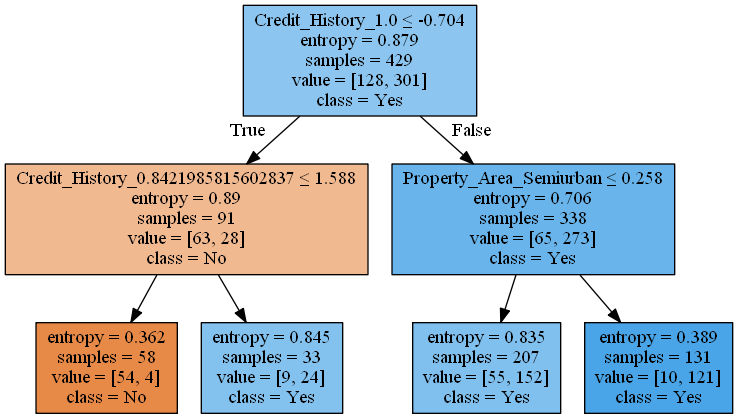

In [22]:
from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

loan_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=53)
loan_tree.fit(X_train, y_train)

featureNames = X.columns
#targetNames = Y.nunique().tolist()
out=tree.export_graphviz(loan_tree, feature_names=featureNames, out_file=dot_data, 
                         class_names= ['No', 'Yes'], filled=True,
                         special_characters=True,rotate=False)
    
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

The 'value' row in each cell tells us the number of values that were classified as [No, Yes].

In order to better understand which predictor variables did have an effect on the algorithm's performances, let's use the feature_importance attribute of sklearn on this classifier.

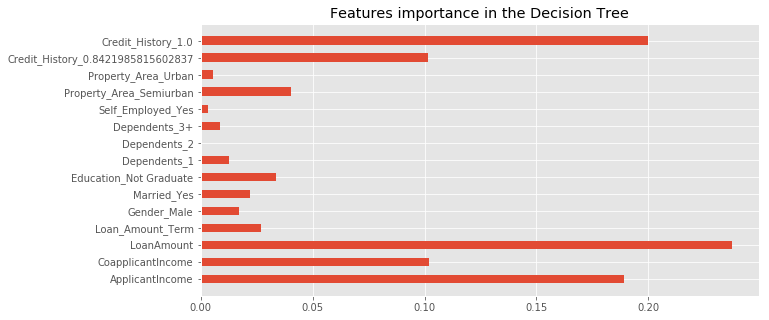

In [23]:
# Train the decision tree
tree = DecisionTreeClassifier(random_state=53)
tree.fit(X_train, y_train)

# List of the importance of each feature
weights = tree.feature_importances_
features = list(X.columns.values)

# Bar plot of the features weights
plt.figure(figsize=(10, 5))

plt.barh(range(len(weights)), weights, height=0.5)

plt.yticks(ticks = range(len(features)), labels = features)
plt.title('Features importance in the Decision Tree')

plt.show()

It's interesting to note that in order to predict whether a loan will be granted or not to an individual, three factors account for more than 60% of the classification : <br>
    . The credit history <br>
    . The applicant income <br>
    . The loan amount <br>

As we can see the individual characteristics (education, marital situation, gender) don't carry much weight in the outcome. It would have been interesting however, to have more details about the applicant's current professional situation (does he have a permanant contract or a fixed-term one for example), as such a parameter might be crucial for the outcome.

__MODEL COMPARISON__

- Confusion matrix

This matrix is a measure of performance, presented as a table of comparison between the predicted values (0/1) and the expected values (0/1). It is useful for us to measure the precision and accuracy of our model but also for other performance measurement tools such as ROC Curve that we'll use just after. <br>

Let's just remember that : <br>
    . Precision = out of all the classes we predicted as positive (prediction = Yes), how many are correct. <br>
    . Recall = out of all the positive classes (loan = Yes), how many did we predict correctly. 

In [24]:
# Compute confusion matrixes
knn_pred = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, knn_pred)

logreg_pred = log_grid.predict(X_test)
cm_log = confusion_matrix(y_test, logreg_pred)

tree_pred = tree_grid.predict(X_test)
cm_tree = confusion_matrix(y_test, tree_pred)

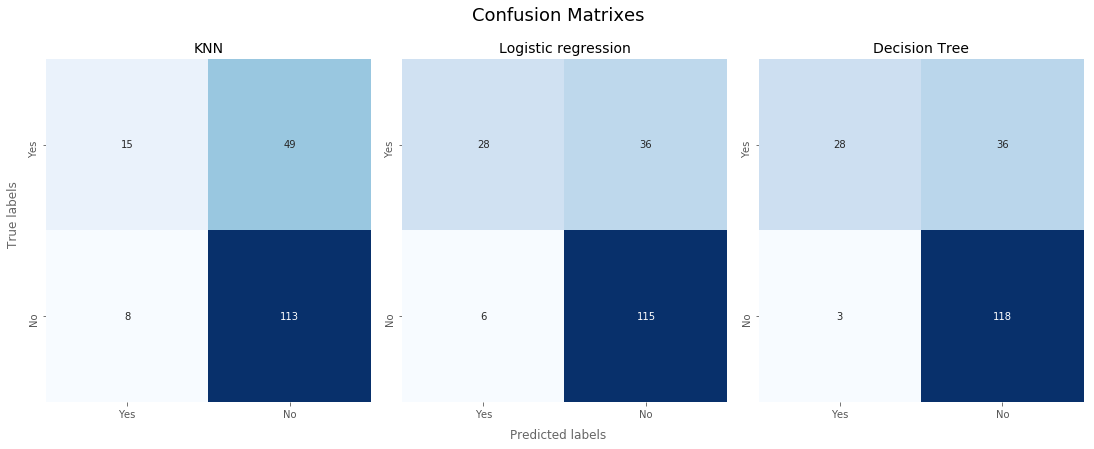

In [25]:
# Graph of the confusion matrixes
fig = plt.figure(figsize=(15, 6))

data = [cm_knn, cm_log, cm_tree]
title = ['KNN', 'Logistic regression', 'Decision Tree']

# Heatmap for each classifier
for i in range(1, 4) :
    ax = fig.add_subplot(1, 3, i)
    
    sns.heatmap(data[i-1], annot=True, fmt="d", cmap="Blues", cbar=False)
    
    ax.set_title(title[i-1], size=14)
    ax.xaxis.set_ticklabels(['Yes', 'No'])
    ax.yaxis.set_ticklabels(['Yes', 'No'])

# Set labels
fig.text(0.5, -0.02, 'Predicted labels', ha='center', size=12, alpha=0.6)
fig.text(-0.01, 0.5, 'True labels', va='center', 
         rotation='vertical', size=12, alpha=0.6)

# Set title
fig.suptitle('Confusion Matrixes', size=18)
fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.show()

<br>

- Precision, Recall and F1-Score 

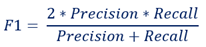

The F-score (or F1) takes in account Precision and Recall at the same time : it uses Harmonic Mean instead of Arithmetic Mean.<br>
An algorithm with a very low score in either metrics will therefore obtain a low F-score, even if the other metrics are high. For example if the Recall is 0, the F1 will be 0 regardless to the Precision.<br>
It ensures the classifier detects a lot of positive classes (high recall), and don't commit too many errors of prediction on this class (high precision). 
<br> <br>

We'll compute and plot the recall, precision and F1-score of each of the previous models and compare the results.

In [26]:
#KNN scores
knn_scores = [precision_score(y_test, knn_pred), 
              recall_score(y_test, knn_pred), 
              f1_score(y_test, knn_pred)]

# Logistic regression scores
log_scores = [precision_score(y_test, logreg_pred), 
              recall_score(y_test, logreg_pred), 
              f1_score(y_test, logreg_pred)]

# Decision tree scores
tree_scores = [precision_score(y_test, tree_pred), 
               recall_score(y_test, tree_pred), 
               f1_score(y_test, tree_pred)]

# Group each score
precision = [knn_scores[0], log_scores[0], tree_scores[0]]
recall = [knn_scores[1], log_scores[1], tree_scores[1]]
f1_score =[knn_scores[2], log_scores[2], tree_scores[2]]

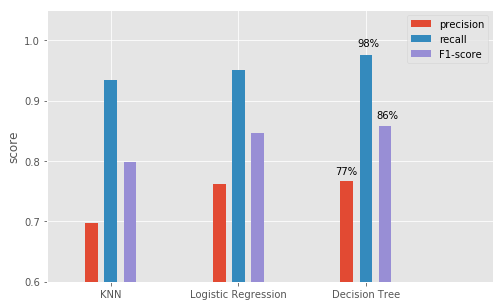

In [27]:
# Graph to compare each model performance
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

width = 0.1
x = np.arange(1, 4)

# Bar plot for each metrics
ax.bar(x - 0.15, precision, width, label='precision')
ax.bar(x, recall, width, label='recall')
ax.bar(x + 0.15, f1_score, width, label='F1-score')

# Annotate the graph
ax.annotate('{:.0%}'.format(max(precision)),
            xy=(2.8, 0.8), xytext=(2.76, 0.778))

ax.annotate('{:.0%}'.format(max(recall)),
            xy=(3, 0.95), xytext=(2.93, 0.99))

ax.annotate('{:.0%}'.format(max(f1_score)),
            xy=(3.2, 0.86), xytext=(3.08, 0.87))

# Set title, axis, label
plt.xticks(x, labels=('KNN', 'Logistic Regression', 'Decision Tree'))
plt.ylabel('score')
plt.legend(loc='best')
plt.xlim(0.5, 4)
plt.ylim(0.6, 1.05)

plt.show()

- ROC Curve and AUC

The ROC (Receiver Operating Characteristics) curve is a performance measurement tool, which tells how much the model can distinguish between classes (Yes or No in our case).
It is the graph of the True Positive rate (TPR, y-axis) with respect to the False Positive rate (DPR, x-axis).

The AUC (Area Under the Curve), is the area under the ROC curve : the higher the area, the better is the model. It represents the proportion, the degree of separability between classes.

When AUC is 1, we can perfectly distinguish the positive from the negative class.
When AUC is 0.8, it means there is 80% chance that our model will be able to distinguish between the two classes.
When AUC is approximately 0.5, model has no discrimination capacity to distinguish between positive and negative class : it performs no better than random chance.

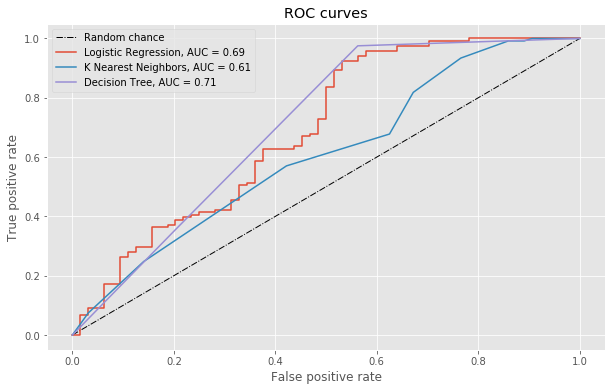

In [28]:
# Graph of the ROC curve
plt.figure(figsize=(10, 6))

#Diagonal line
plt.plot([0, 1], [0, 1], 'k-.', lw=1, label='Random chance')
plt.legend()

# Log reg curve
logreg_pred = logreg.predict_proba(X_test)[:,1]
fp, tp, _ = roc_curve(y_test, logreg_pred)
plt.plot(fp, tp, label='Logistic Regression, AUC = %.02f' %auc(fp, tp))

# KNN curve
knn_pred_proba = knn.predict_proba(X_test)[:,1]
fp_knn, tp_knn, _ = roc_curve(y_test, knn_pred_proba)
plt.plot(fp_knn, tp_knn, label="K Nearest Neighbors, AUC = %.02f" %auc(fp_knn, tp_knn))

# Decision tree curve
tree_pred_proba = tree_grid.predict_proba(X_test)[:,1]
fp_tree, tp_tree, _ = roc_curve(y_test, tree_pred_proba)
plt.plot(fp_tree, tp_tree, label='Decision Tree, AUC = %.02f' %auc(fp_tree, tp_tree))

#Set title, axis, legend
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend()

plt.show()